In [13]:
import os
import glob
import pandas as pd
from tensorboard.backend.event_processing import event_accumulator
import seaborn as sns
import matplotlib.pyplot as plt

In [11]:
def load_all_tb_scalars(log_root: str) -> pd.DataFrame:
    rows = []

    event_files = glob.glob(
        os.path.join(log_root, "**", "events.out.tfevents.*"), recursive=True
    )

    print(f"Found files: {len(event_files)}")

    for event_file in event_files:
        event_dir = os.path.dirname(event_file)
        model_dir = os.path.dirname(event_dir)
        model_name = os.path.basename(model_dir)

        ea = event_accumulator.EventAccumulator(
            event_file,
            size_guidance={event_accumulator.SCALARS: 0},
        )
        ea.Reload()

        if "scalars" not in ea.Tags():
            continue

        for tag in ea.Tags()["scalars"]:
            events = ea.Scalars(tag)
            for e in events:
                rows.append(
                    {
                        "model": model_name,
                        "tag": tag,
                        "epoch": e.step,
                        "value": e.value,
                    }
                )

    return pd.DataFrame(rows)


df = load_all_tb_scalars("../data/logs")

Found files: 9


In [12]:
df[df['model'] == 'efficientnet']

,model,tag,epoch,value
749,efficientnet,train/loss,0,1.534028
750,efficientnet,train/loss,1,0.471867
751,efficientnet,train/loss,2,0.266107
752,efficientnet,train/loss,3,0.186415
753,efficientnet,train/loss,4,0.139944
...,...,...,...,...
947,efficientnet,val/f1,24,0.989388
948,efficientnet,val/f1,25,0.992578
949,efficientnet,val/f1,26,0.992342
950,efficientnet,val/f1,27,0.992578


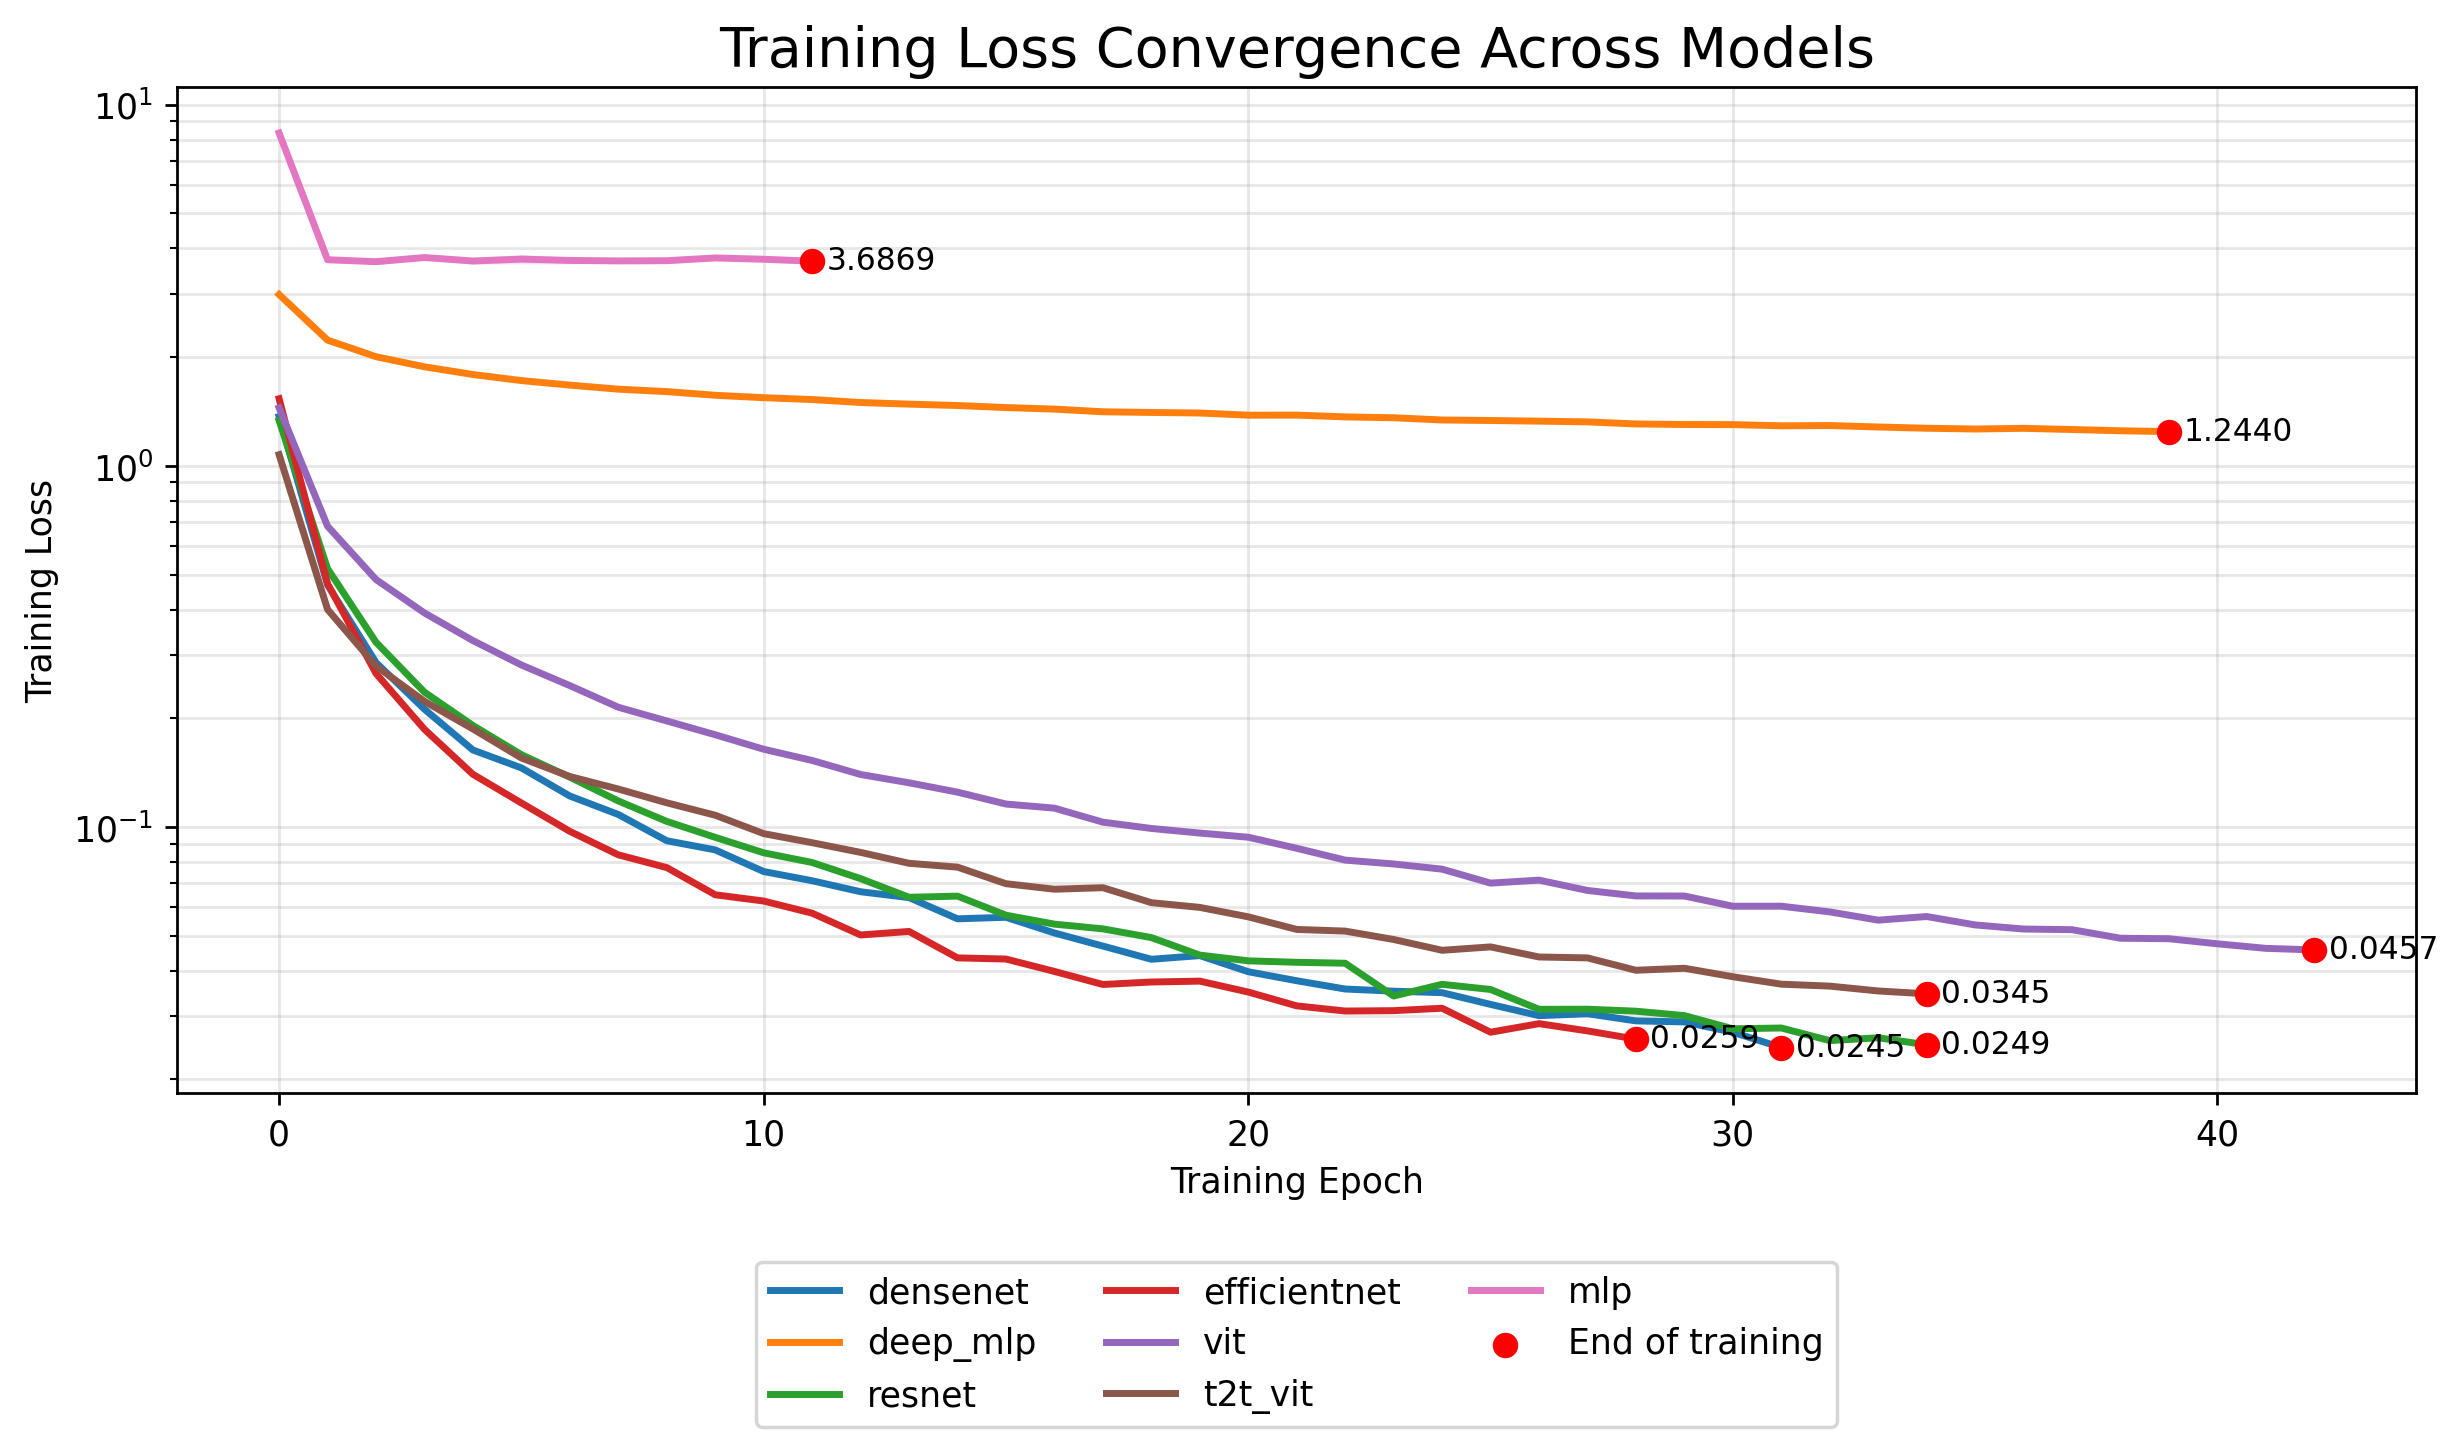

In [49]:
import seaborn as sns
import matplotlib.pyplot as plt

tag = "train/loss"
bad_models = []
df_loss = df[(df["tag"] == tag) & (~df["model"].isin(bad_models))].copy()
last_points = df_loss.sort_values(["model", "epoch"]).groupby("model").tail(1)

plt.figure(figsize=(10, 6), dpi=250)

lineplot = sns.lineplot(data=df_loss, x="epoch", y="value", hue="model", linewidth=2)
scatter = plt.scatter(last_points["epoch"], last_points["value"], color="red", s=40, zorder=10)

for _, row in last_points.iterrows():
    plt.text(
        row["epoch"] + 0.3,
        row["value"],
        f"{row['value']:.4f}",
        color="black",
        fontsize=9,
        verticalalignment="center"
    )

plt.yscale("log")
plt.title("Training Loss Convergence Across Models", fontsize=16)
plt.xlabel("Training Epoch")
plt.ylabel("Training Loss")
plt.grid(alpha=0.3, which="both")

handles, labels = plt.gca().get_legend_handles_labels()
handles.append(scatter)
labels.append("End of training")

plt.legend(handles=handles, labels=labels, loc="upper center", bbox_to_anchor=(0.5, -0.15), ncol=3, fontsize=10)
plt.tight_layout()
plt.show()
